
# Natural Language Inference on “Contradictory, My Dear Watson”
#### Author: James Coffey   
#### Date: 2025‑08‑17
#### Challenge URL: [Contradictory, My Dear Watson](https://www.kaggle.com/competitions/contradictory-my-dear-watson)

# Discussion

This notebook tackles multilingual Natural Language Inference (NLI) for the
Kaggle **Contradictory, My Dear Watson** dataset. Below I explain what I built
and why, what I observed about the data and models, how the results shook out,
and what I’d change next.

## Implementation decisions

* **Hardware:** I ran **GPU‑only (T4×2)** with `MirroredStrategy` and **mixed
  precision**. In practice, TPUs on Kaggle can be hit‑or‑miss to initialize;
  GPUs gave me a simpler, robust path and good throughput.
* **Data split:** I kept a **classic 80/20 split stratified by label** (no
  challenge set), which proved more stable for validation accuracy in my runs.
* **Preprocessing:** Minimal. No lowercasing/punctuation removal. I **removed
  `[lang]` prefixes** after seeing they hurt validation when not registered as
  true special tokens and used consistently.
* **Baselines:** A quick **TF‑IDF → LinearSVC** baseline to sanity‑check the
  pipeline.
* **Transformers:** I compared three multilingual checkpoints:

  * `microsoft/mdeberta-v3-base`
  * `bert-base-multilingual-cased`
  * `xlm-roberta-base` I avoided `xlm-roberta-large` due to OOM on GPUs.

* **Optimization:** Warmup + weight decay via `transformers.create_optimizer`,
  **label smoothing = 0.05**, early stopping on `val_accuracy`, fixed
  `MAX_LEN=128`.
* **Packaging:** Saved **tokenizer**, **SavedModel**, and **weights**, and added
  a small `predict_pair()` utility. I **skipped ONNX** export because it was
  CPU/RAM heavy and slowed the workflow.

## Key observations about the data

* **Language distribution** is uneven (as expected in CMDW). This matters for
  stratification and for interpreting per‑language accuracy.
* **Sentence length varies widely by language.** For example, Vietnamese
  premises are relatively long on average, while Thai and Chinese appear very
  short in whitespace‑token counts (tokenizer‑dependent in practice).
* **Label semantics are asymmetric** in difficulty: neutral vs entailment can be
  especially subtle, and that ambiguity shows up in the confusion matrix.

## Key observations about the models

* **mDeBERTa‑v3‑base was consistently strongest**, likely due to the
  disentangled attention and modern training recipe. It converged quickly and
  kept its edge even with conservative hyperparameters.
* **mBERT (cased)** was solid and predictable, landing in the mid‑0.6s on
  validation with this setup.
* **XLM‑R base lagged** here. With identical training code, it hovered near
  chance early on and improved only slightly. This suggests it wanted a
  different LR schedule, more steps, longer `max_len`, or simply better
  regularization for this exact split. (It also doesn’t use `token_type_ids`,
  which the code handles.)
* **Label smoothing (0.05)** behaved well with one‑hot labels and
  `CategoricalCrossentropy(from_logits=True)`, reducing over‑confidence without
  hurting peak accuracy.
* **Mixed precision** provided speed/memory benefits without numerical issues
  once logits were cast back to `float32` for loss/metrics.

## Key observations about results

* **Validation:** Best run reached **~0.791 val accuracy** with
  `mdeberta‑v3‑base` (early peak around epochs 5–7). mBERT hit ~0.67; XLM‑R base
  lagged in the mid‑0.34–0.36 range in this specific configuration.
* **Per‑language validation accuracy (macro ≈ 0.768):** High 0.8s for Spanish,
  Vietnamese, French, English; mid 0.7s for German/Greek/Russian; lower for
  Swahili/Urdu/Thai. This lines up with typical resource and script differences.
* **Confusion matrix:** Most errors are **entailment vs neutral** swaps;
  contradictions are more cleanly identified. That’s consistent with NLI
  literature where neutral is the "catch‑all" that often absorbs borderline
  entailments.
* **Leaderboard:** With the chosen configuration and single best‑model
  inference, I obtained a score around **0.777** on the public LB, in line with
  validation.

## How I would improve the model next

1. **Make language tags *true* special tokens** (if I bring them back):

   * Add `[xx]` tokens to the tokenizer via `additional_special_tokens` and
     **resize embeddings**.
   * Use them consistently for **train/val/test**. In past work, this helps
     multilingual transfer when done correctly.

2. **Better splits for robustness:**

   * Stratify by **label+language**, and optionally keep a small **low‑resource
     "challenge" set** to monitor tail‑language generalization.
   * Add **K‑fold CV** over stratified folds to stabilize model selection.

3. **Hyperparameter sweep (small but targeted):**

   * Try `max_len=256` for mDeBERTa (it often helps on longer premises).
   * Sweep LR around the current values (e.g., {1e‑5, 2e‑5, 3e‑5}) with a fixed
     warmup ratio.
   * Consider **cosine decay** and slightly longer training with patience.

4. **Training tricks:**

   * **Freeze early layers** for a few epochs, then unfreeze (gradual
     unfreezing) to reduce overfitting early on.
   * Explore **R‑Drop** / consistency regularization or light **adversarial
     weight perturbation (AWP)** for stability.

5. **Ensembling & calibration:**

   * Simple **average‑logit ensemble** of 2–3 strong checkpoints (e.g., mDeBERTa
     + mBERT) usually yields +0.5–1.0pp.
   * Apply **temperature scaling** on a held‑out set to calibrate probabilities.

6. **Data augmentation:**

   * **Back‑translation** or **round‑trip translation** for low‑resource
     languages to reduce variance.
   * Light **premise/hypothesis paraphrases** where available, with care not to
     flip labels.

7. **Infrastructure:**

   * If a TPU becomes easy to acquire, try **`xlm‑roberta‑large`** or
     **`deberta‑v3‑large`** with larger batches and `max_len=256`.

## Closing notes

This pipeline is intentionally simple: one clean split, clear baselines, a few
strong multilingual checkpoints, and minimal knobs. Even so, mDeBERTa‑v3‑base
lands near 0.77–0.80 on validation and ≈0.777 on the public leaderboard. The
biggest near‑term wins are likely from stratifying by label+language with CV, a
small LR/length sweep, and either ensembling or properly‑implemented language
tags. The rest are incremental layers of polish depending on runtime budget.


# Setup & Environment

## Why not use TPU?

Here’s why I’m using **GPU (T4×2)** instead of a TPU:

Using TPUs on Kaggle can be hit-or-miss due to capacity and availability. They require a separate initialization path (TPU-VM / resolver setup) that adds friction. If a TPU isn’t actually attached, TensorFlow will fail at initialization. On the other hand, NVIDIA GPUs are a great default. Mixed-precision training in Keras is officially supported and typically speeds up training while reducing memory use, and Tensor Cores can deliver large gains on matrix operations (the core of transformer models). Finally, the Hugging Face TF stack tends to be simpler and stabler on GPU (no TPU resolver steps).

In [ ]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "1"  # HF TF models expect Keras-2 API
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Quieter logs
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "1"  # Quieter tokenizer logs

import gc

import tensorflow as tf
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    create_optimizer,
)
from transformers.utils import logging as hf_logging

hf_logging.set_verbosity_error()  # suppress HF advisory spam

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC

# Reproducibility
SEED = 42
tf.keras.utils.set_random_seed(SEED)

# Safer VRAM handling
gpus = tf.config.list_physical_devices("GPU")
for g in gpus:
    try:
        tf.config.experimental.set_memory_growth(g, True)
    except Exception:
        pass

# Use both T4s + automatic mixed precision
strategy = tf.distribute.MirroredStrategy()
tf.keras.mixed_precision.set_global_policy("mixed_float16")
print("Replicas:", strategy.num_replicas_in_sync)

2025-08-17 16:46:01.640164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755449161.662245     113 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755449161.669005     113 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Replicas: 2


I0000 00:00:1755449177.232246     113 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755449177.233009     113 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


# Data

The training set contains a premise, a hypothesis, a label (0 = entailment, 1 = neutral, 2 = contradiction), and the language of the text.

In [2]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
labels = train["label"].astype("int32").to_numpy()
train.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


# Exploratory Data Analysis (EDA)

## Example Pair

The pair below is contradictory.

In [3]:
train.premise.values[1]

'These are issues that we wrestle with in practice groups of law firms, she said. '

In [4]:
train.hypothesis.values[1]

'Practice groups are not permitted to work on these issues.'

In [5]:
train.label.values[1]

2

## Language Distribution

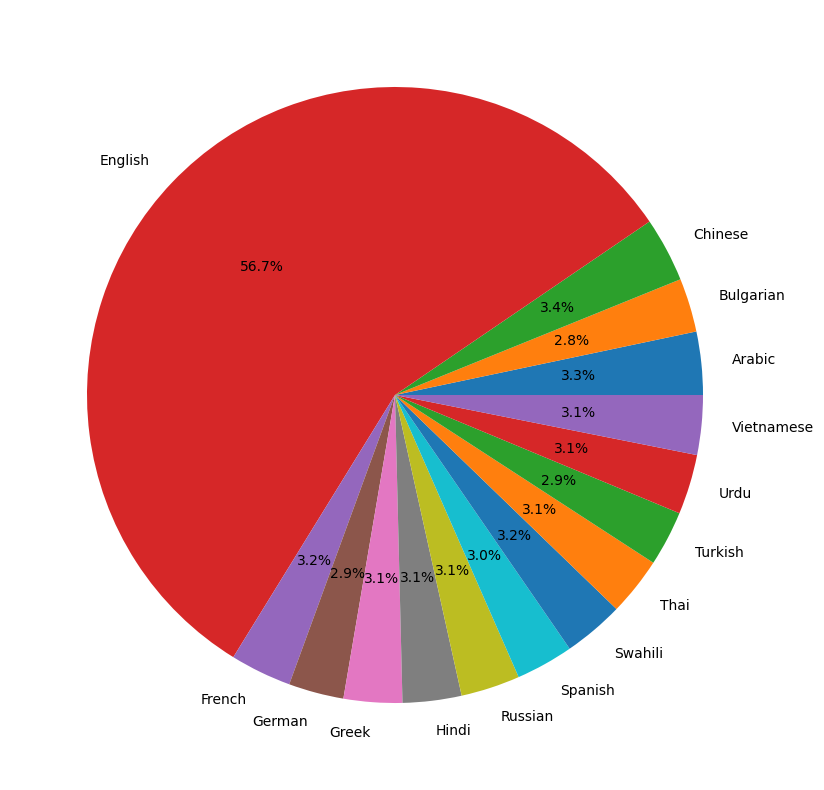

In [6]:
languages, counts = np.unique(train.language.values, return_counts=True)

plt.figure(figsize=(10, 10))
plt.pie(counts, labels=languages, autopct="%1.1f%%")
plt.show()

## Avg Sentence Length by Language

,p_len,h_len
language,,
Vietnamese,25.166227,12.572559
Urdu,21.301837,11.162730
Hindi,21.131016,11.016043
French,19.787179,10.343590
Spanish,19.642077,9.863388
English,19.314119,9.938865
Greek,18.793011,9.258065
Bulgarian,17.891813,8.976608
German,17.433048,8.960114


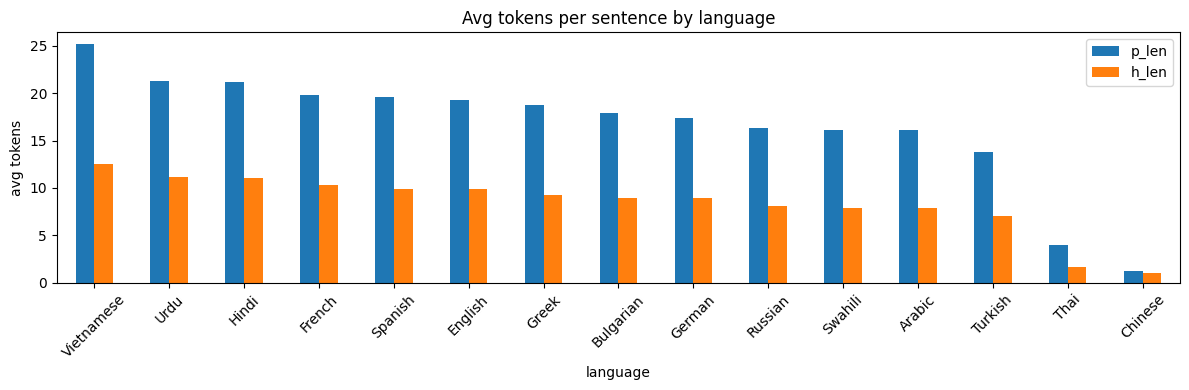

In [7]:
# Avg token lengths per language (premise & hypothesis)
lens = (
    train.assign(
        p_len=train["premise"].str.split().str.len(),
        h_len=train["hypothesis"].str.split().str.len(),
    )
    .groupby("language")[["p_len", "h_len"]]
    .mean()
    .sort_values("p_len", ascending=False)
)

display(lens.head(20))
ax = lens.plot(kind="bar", figsize=(12, 4), rot=45, ylabel="avg tokens")
ax.set_title("Avg tokens per sentence by language")
plt.tight_layout()
plt.show()

# Preprocessing & Splits

## Split the data

In [8]:
# Classic 80/20 split, stratified by label
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=SEED)
idx_tr, idx_val = next(sss.split(np.zeros(len(labels)), labels))

## Training parameters

In [9]:
EPOCHS = 10
MAX_LEN = 128
NUM_CLASSES = 3
LABEL_SMOOTHING = 0.05

# conservative per‑GPU batch that fits mBERT/XLM‑R on T4; DeBERTa v3 is heavier
BATCH_PER_DEVICE_MAP = {
    "bert-base-multilingual-cased": 16,
    "microsoft/mdeberta-v3-base": 8,  # heavier, keep small
    "xlm-roberta-base": 10,  # a touch lower
}

LR_MAP = {
    "bert-base-multilingual-cased": 2e-5,
    "microsoft/mdeberta-v3-base": 2e-5,
    "xlm-roberta-base": 3e-5,  # bump helps XLM-R
}

CHECKPOINTS = [
    "bert-base-multilingual-cased",
    "microsoft/mdeberta-v3-base",
    "xlm-roberta-base",
]

## Utilities

In [ ]:
AUTO = tf.data.AUTOTUNE


def tokenize_pairs(
    tokenizer, premises, hypotheses, max_len=MAX_LEN, return_tensors="np"
):
    """Tokenizes premise–hypothesis pairs for transformer encoders.

    This helper wraps a Hugging Face tokenizer to produce fixed-length,
    model-ready inputs for Natural Language Inference (NLI). It pads/truncates
    both sequences to ``max_len`` and returns tensors/arrays according to
    ``return_tensors``.

    Args:
      tokenizer: A Hugging Face tokenizer (e.g., ``AutoTokenizer`` instance)
        that implements ``__call__`` for pair encoding.
      premises: Sequence of strings (or a pandas ``Series``) containing the
        premise texts.
      hypotheses: Sequence of strings (or a pandas ``Series``) containing the
        hypothesis texts.
      max_len: Integer maximum sequence length to pad/truncate to. Must match
        the input shape used to build the Keras model (e.g., ``MAX_LEN``).
      return_tensors: One of {``"np"``, ``"tf"``, ``"pt"``}. Controls the
        tensor backend of the returned encoding.

    Returns:
      A dict mapping feature names to arrays/tensors, typically including
      ``"input_ids"`` and ``"attention_mask"`` and (for some models) optional
      ``"token_type_ids"``. The value types depend on ``return_tensors``.

    Notes:
      * Padding mode is ``"max_length"`` to ensure a fixed-length batchable
        shape.
      * Truncation is applied to respect ``max_len``.
    """
    return tokenizer(
        list(premises),
        list(hypotheses),
        padding="max_length",
        truncation=True,
        max_length=max_len,
        return_tensors=return_tensors,
    )


def make_ds(enc, y=None, batch_size=32, train=True):
    """Builds a ``tf.data.Dataset`` from tokenized inputs (and labels).

    Creates a dataset of feature dictionaries suitable for feeding a compiled
    Keras model. If labels ``y`` are provided (integer class IDs), they are
    converted to one-hot vectors of size ``NUM_CLASSES`` so that
    ``CategoricalCrossentropy(from_logits=True, label_smoothing=...)`` can be
    used consistently.

    Args:
      enc: Mapping from feature names to arrays/tensors (e.g., output of
        :func:`tokenize_pairs`). Recognized keys are ``"input_ids"``,
        ``"attention_mask"``, and optional ``"token_type_ids"``.
      y: Optional 1D array-like of integer class labels with shape
        ``(num_examples,)``. If ``None``, an unlabeled dataset is created.
      batch_size: Integer batch size for the returned dataset.
      train: If ``True``, the labeled dataset is shuffled with a fixed seed for
        reproducibility. Ignored when ``y`` is ``None``.

    Returns:
      Tuple[tf.data.Dataset, List[str]]: A batched & prefetched dataset and the
      ordered list of feature keys used to build model inputs.

    Raises:
      ValueError: If required feature keys are missing from ``enc``.

    Notes:
      * The dataset is prefetched with ``AUTO`` for pipeline efficiency.
      * Shuffling uses ``SEED`` and the full dataset length for robust mixing.
    """
    feature_keys = [
        k for k in ("input_ids", "attention_mask", "token_type_ids") if k in enc
    ]
    x = {k: enc[k] for k in feature_keys}
    if y is not None:
        # One-hot labels so we can use CategoricalCrossentropy with label_smoothing
        y_arr = tf.convert_to_tensor(y, dtype=tf.int32)
        y_arr = tf.one_hot(y_arr, depth=NUM_CLASSES)
        ds = tf.data.Dataset.from_tensor_slices((x, y_arr))
        if train:
            ds = ds.shuffle(len(y), seed=SEED, reshuffle_each_iteration=True)
    else:
        ds = tf.data.Dataset.from_tensor_slices(x)
    return ds.batch(batch_size).prefetch(AUTO), feature_keys


def load_tf_sequence_classifier(model_ckpt, num_labels=3):
    """Loads a TF sequence-classification model with a PyTorch fallback.

    Attempts to load a ``TFAutoModelForSequenceClassification`` for the given
    checkpoint. If native TensorFlow weights are unavailable, retries with
    ``from_pt=True`` to convert from PyTorch weights on the fly.

    Args:
      model_ckpt: Model checkpoint name or local path understood by
        ``transformers`` (e.g., ``"microsoft/mdeberta-v3-base"``).
      num_labels: Number of target classes for the classification head.

    Returns:
      A ``TFAutoModelForSequenceClassification`` instance configured with
      ``num_labels``.

    Raises:
      Any exception raised by Hugging Face Transformers if both the TF and
      PyTorch loading paths fail. This function prints an informational message
      before attempting the PyTorch fallback.
    """
    try:
        return TFAutoModelForSequenceClassification.from_pretrained(
            model_ckpt, num_labels=num_labels
        )
    except Exception:
        print(
            f"[Info] Native TF weights not found for {model_ckpt}. Trying from_pt=True …"
        )
        return TFAutoModelForSequenceClassification.from_pretrained(
            model_ckpt, num_labels=num_labels, from_pt=True
        )

# Baseline: TF-IDF + LinearSVC

In [ ]:
def join_pair(df):
    """Concatenates premise and hypothesis for classic bag-of-words baselines.

    Produces a text input of the form ``"<premise> [SEP] <hypothesis>"`` used by
    the TF‑IDF + LinearSVC baseline.

    Args:
      df: ``pandas.DataFrame`` containing ``"premise"`` and ``"hypothesis"``
        columns.

    Returns:
      List[str]: Concatenated strings suitable for vectorization.
    """
    return (df["premise"] + " [SEP] " + df["hypothesis"]).tolist()


Xtr_txt = join_pair(train.loc[idx_tr])
ytr = labels[idx_tr]
Xva_txt = join_pair(train.loc[idx_val])
yva = labels[idx_val]

tfidf_svm = make_pipeline(
    TfidfVectorizer(
        ngram_range=(1, 2), max_features=200_000, token_pattern=r"(?u)\b\w+\b"
    ),
    LinearSVC(),
)
tfidf_svm.fit(Xtr_txt, ytr)
svm_val_acc = (tfidf_svm.predict(Xva_txt) == yva).mean()
print(f"TF-IDF LinearSVC val_acc = {svm_val_acc:.4f}")

TF-IDF LinearSVC val_acc = 0.2442


# Transformer Training

In [ ]:
results = []
saved_weight_files = {}  # Track best-weight files per model

for ckpt in CHECKPOINTS:
    print("\n===============================")
    print(f"Training: {ckpt}")
    print("===============================")

    tokenizer = AutoTokenizer.from_pretrained(ckpt, use_fast=True)

    # Tokenize with the model's tokenizer
    tr_enc = tokenize_pairs(
        tokenizer,
        train.loc[idx_tr, "premise"],
        train.loc[idx_tr, "hypothesis"],
        MAX_LEN,
    )
    va_enc = tokenize_pairs(
        tokenizer,
        train.loc[idx_val, "premise"],
        train.loc[idx_val, "hypothesis"],
        MAX_LEN,
    )
    te_enc = tokenize_pairs(
        tokenizer,
        test["premise"],
        test["hypothesis"],
        MAX_LEN,
    )

    # Build datasets (features adapt to presence/absence of token_type_ids)
    per_device = BATCH_PER_DEVICE_MAP.get(ckpt, 12)
    global_batch = per_device * strategy.num_replicas_in_sync
    train_ds, feature_keys = make_ds(
        tr_enc, y=labels[idx_tr], batch_size=global_batch, train=True
    )
    val_ds, _ = make_ds(va_enc, y=labels[idx_val], batch_size=global_batch, train=False)

    steps_per_epoch = int(np.ceil(len(idx_tr) / global_batch))
    total_steps = steps_per_epoch * EPOCHS
    warmup_steps = int(0.1 * total_steps)

    with strategy.scope():
        optimizer, lr_schedule = create_optimizer(
            init_lr=LR_MAP.get(ckpt, 2e-5),
            num_train_steps=total_steps,
            num_warmup_steps=warmup_steps,
            weight_decay_rate=0.01,
        )
        base = load_tf_sequence_classifier(ckpt, num_labels=3)
        # Plain Keras model; cast logits for AMP stability
        inputs = {
            k: tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name=k)
            for k in feature_keys
        }
        logits = tf.cast(base(inputs).logits, tf.float32, name="logits_float32")
        model = tf.keras.Model(inputs=inputs, outputs=logits)
        model.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.CategoricalCrossentropy(
                from_logits=True, label_smoothing=LABEL_SMOOTHING
            ),
            metrics=[tf.keras.metrics.CategoricalAccuracy(name="accuracy")],
        )

    # Train
    ckpt_file = f"best_{ckpt.replace('/', '_')}.weights.h5"
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            ckpt_file,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,
            verbose=1,
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=3, restore_best_weights=True
        ),
    ]
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=callbacks,
        verbose=1,
    )

    # Track metrics
    val_acc_hist = hist.history["val_accuracy"]
    best_val = float(np.max(val_acc_hist))
    best_epoch = int(np.argmax(val_acc_hist)) + 1

    saved_weight_files[ckpt] = ckpt_file

    try:
        del model, base
    except Exception:
        pass
    tf.keras.backend.clear_session()
    gc.collect()

    results.append(
        {
            "model": ckpt,
            "max_len": MAX_LEN,
            "per_gpu_batch": per_device,
            "global_batch": global_batch,
            "best_val_acc": best_val,
            "best_epoch": best_epoch,
        }
    )


Training: bert-base-multilingual-cased


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Epoch 1/10
303/303 [==============================] - ETA: 0s - loss: 1.0279 - accuracy: 0.4610
Epoch 1: val_accuracy improved from -inf to 0.63243, saving model to best_bert-base-multilingual-cased.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


303/303 [==============================] - 193s 421ms/step - loss: 1.0279 - accuracy: 0.4610 - val_loss: 0.8735 - val_accuracy: 0.6324
Epoch 2/10
303/303 [==============================] - ETA: 0s - loss: 0.7911 - accuracy: 0.6775
Epoch 2: val_accuracy improved from 0.63243 to 0.67162, saving model to best_bert-base-multilingual-cased.weights.h5
303/303 [==============================] - 120s 395ms/step - loss: 0.7911 - accuracy: 0.6775 - val_loss: 0.8044 - val_accuracy: 0.6716
Epoch 3/10
303/303 [==============================] - ETA: 0s - loss: 0.5787 - accuracy: 0.8060
Epoch 3: val_accuracy did not improve from 0.67162
303/303 [==============================] - 117s 385ms/step - loss: 0.5787 - accuracy: 0.8060 - val_loss: 0.8630 - val_accuracy: 0.6597
Epoch 4/10
303/303 [==============================] - ETA: 0s - loss: 0.4138 - accuracy: 0.8861
Epoch 4: val_accuracy did not improve from 0.67162
303/303 [==============================] - 117s 385ms/step - loss: 0.4138 - accuracy: 0.

tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


tf_model.h5:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Epoch 1/10
606/606 [==============================] - ETA: 0s - loss: 1.0197 - accuracy: 0.4512
Epoch 1: val_accuracy improved from -inf to 0.71452, saving model to best_microsoft_mdeberta-v3-base.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


606/606 [==============================] - 428s 527ms/step - loss: 1.0197 - accuracy: 0.4512 - val_loss: 0.7607 - val_accuracy: 0.7145
Epoch 2/10
606/606 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.7618
Epoch 2: val_accuracy improved from 0.71452 to 0.77558, saving model to best_microsoft_mdeberta-v3-base.weights.h5
606/606 [==============================] - 299s 494ms/step - loss: 0.6628 - accuracy: 0.7618 - val_loss: 0.6239 - val_accuracy: 0.7756
Epoch 3/10
606/606 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.8643
Epoch 3: val_accuracy improved from 0.77558 to 0.78012, saving model to best_microsoft_mdeberta-v3-base.weights.h5
606/606 [==============================] - 299s 493ms/step - loss: 0.4620 - accuracy: 0.8643 - val_loss: 0.6732 - val_accuracy: 0.7801
Epoch 4/10
606/606 [==============================] - ETA: 0s - loss: 0.3464 - accuracy: 0.9245
Epoch 4: val_accuracy did not improve from 0.78012
606/606 [=================

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Epoch 1/10
485/485 [==============================] - ETA: 0s - loss: 1.0987 - accuracy: 0.3472
Epoch 1: val_accuracy improved from -inf to 0.34777, saving model to best_xlm-roberta-base.weights.h5


/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


485/485 [==============================] - 259s 409ms/step - loss: 1.0987 - accuracy: 0.3472 - val_loss: 1.0976 - val_accuracy: 0.3478
Epoch 2/10
485/485 [==============================] - ETA: 0s - loss: 1.0986 - accuracy: 0.3530
Epoch 2: val_accuracy did not improve from 0.34777
485/485 [==============================] - 183s 378ms/step - loss: 1.0986 - accuracy: 0.3530 - val_loss: 1.0957 - val_accuracy: 0.3445
Epoch 3/10
485/485 [==============================] - ETA: 0s - loss: 1.1011 - accuracy: 0.3431
Epoch 3: val_accuracy did not improve from 0.34777
485/485 [==============================] - 183s 377ms/step - loss: 1.1011 - accuracy: 0.3431 - val_loss: 1.0987 - val_accuracy: 0.3445
Epoch 4/10
485/485 [==============================] - ETA: 0s - loss: 1.1003 - accuracy: 0.3432
Epoch 4: val_accuracy did not improve from 0.34777
485/485 [==============================] - 183s 377ms/step - loss: 1.1003 - accuracy: 0.3432 - val_loss: 1.1010 - val_accuracy: 0.3445


# Model Selection

In [13]:
scoreboard = pd.DataFrame(results).sort_values("best_val_acc", ascending=False)
print("\nValidation scoreboard:\n", scoreboard)
scoreboard.to_csv("model_val_scoreboard.csv", index=False)

best_row = scoreboard.iloc[0]
best_ckpt = best_row["model"]
print(
    f"\nBest model: {best_ckpt} — val_acc={best_row['best_val_acc']:.4f} @ epoch {best_row['best_epoch']}"
)

# Load best transformer model
per_device = BATCH_PER_DEVICE_MAP.get(best_ckpt, 12)
global_batch = per_device * strategy.num_replicas_in_sync

best_tokenizer = AutoTokenizer.from_pretrained(best_ckpt, use_fast=True)
te_enc = tokenize_pairs(best_tokenizer, test["premise"], test["hypothesis"], MAX_LEN)
feature_keys = [
    k for k in ("input_ids", "attention_mask", "token_type_ids") if k in te_enc
]

with strategy.scope():
    base = load_tf_sequence_classifier(best_ckpt, num_labels=3)
    inputs = {
        k: tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name=k)
        for k in feature_keys
    }
    logits = tf.cast(base(inputs).logits, tf.float32)
    best_model = tf.keras.Model(inputs=inputs, outputs=logits)
    best_model.load_weights(saved_weight_files[best_ckpt])


Validation scoreboard:
                           model  max_len  per_gpu_batch  global_batch  \
1    microsoft/mdeberta-v3-base      128              8            16   
0  bert-base-multilingual-cased      128             16            32   
2              xlm-roberta-base      128             10            20   

   best_val_acc  best_epoch  
1      0.791254           5  
0      0.671617           2  
2      0.347772           1  

Best model: microsoft/mdeberta-v3-base — val_acc=0.7913 @ epoch 5


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


# Evaluation

In [14]:
va_enc = tokenize_pairs(
    best_tokenizer,
    train.loc[idx_val, "premise"],
    train.loc[idx_val, "hypothesis"],
    MAX_LEN,
)
val_ds = (
    tf.data.Dataset.from_tensor_slices({k: va_enc[k] for k in feature_keys})
    .batch(global_batch)
    .prefetch(AUTO)
)
val_logits = best_model.predict(val_ds, verbose=0)
val_pred = np.argmax(val_logits, axis=-1)
y_val = labels[idx_val]
va_lang = train.loc[idx_val, "language"].values
df_eval = pd.DataFrame({"lang": va_lang, "y_true": y_val, "y_pred": val_pred})
per_lang_acc = (
    df_eval.groupby("lang")
    .apply(lambda g: (g.y_true == g.y_pred).mean())
    .sort_values(ascending=False)
)
print("Per-language accuracy:\n", per_lang_acc.to_string())
print(f"\nMacro avg: {per_lang_acc.mean():.4f}")

Per-language accuracy:
 lang
Spanish       0.867470
Vietnamese    0.835821
French        0.813559
English       0.813146
Arabic        0.810127
German        0.805970
Greek         0.779221
Russian       0.765957
Bulgarian     0.760563
Turkish       0.753846
Chinese       0.737864
Hindi         0.732558
Thai          0.714286
Swahili       0.666667
Urdu          0.657143

Macro avg: 0.7676


/tmp/ipykernel_113/3975729045.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: (g.y_true == g.y_pred).mean())


## Confusion Matrix

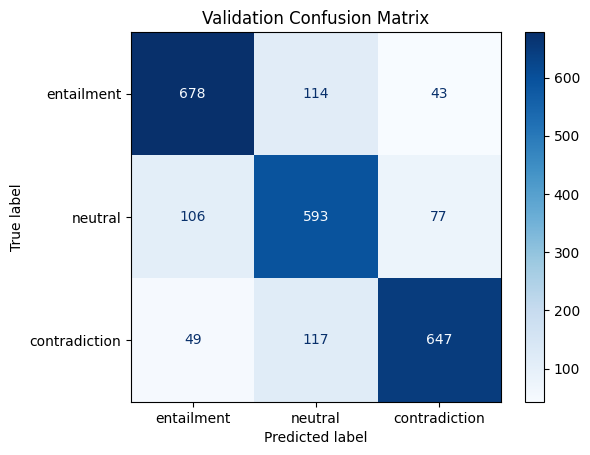

In [15]:
ConfusionMatrixDisplay.from_predictions(
    y_val,
    val_pred,
    display_labels=["entailment", "neutral", "contradiction"],
    cmap="Blues",
)
plt.title("Validation Confusion Matrix")
plt.show()

# Inference on Test

In [16]:
infer_ds = (
    tf.data.Dataset.from_tensor_slices({k: te_enc[k] for k in feature_keys})
    .batch(global_batch)
    .prefetch(tf.data.AUTOTUNE)
)
logits = best_model.predict(infer_ds, verbose=1).squeeze()
preds = tf.argmax(logits, axis=-1).numpy()

submission = pd.DataFrame({"id": test["id"], "prediction": preds})
submission.to_csv("submission.csv", index=False)
print("Wrote submission.csv and model_val_scoreboard.csv")

325/325 [==============================] - 21s 64ms/step
Wrote submission.csv and model_val_scoreboard.csv


# Packaging

## Save tokenizer, wieghts, & TF SavedModel

In [18]:
os.makedirs("export", exist_ok=True)
best_tokenizer.save_pretrained("export/tokenizer")
best_model.save_weights("export/best_model.weights.h5")
best_model.save("export/tf_saved_model")

/usr/local/lib/python3.11/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


## Small predict utility

In [ ]:
ID2LAB = {0: "entailment", 1: "neutral", 2: "contradiction"}
FEATURE_KEYS_BEST = tuple(feature_keys)


def predict_pair(premise: str, hypothesis: str) -> int:
    """Runs a single NLI prediction using the globally loaded best model.

    This utility pads/truncates inputs to ``MAX_LEN`` and forwards only the
    feature keys the compiled model expects (e.g., XLM‑R does not use
    ``token_type_ids``). It relies on the global ``best_tokenizer``,
    ``best_model``, and ``FEATURE_KEYS_BEST`` prepared in the notebook.

    Args:
      premise: The premise sentence.
      hypothesis: The hypothesis sentence.

    Returns:
      int: Predicted class ID where ``0=entailment``, ``1=neutral``,
      ``2=contradiction``.

    Raises:
      RuntimeError: If the global model/tokenizer have not been initialized.
      KeyError: If required feature keys are missing from the tokenizer output.

    Example:
      >>> ID2LAB = {0: "entailment", 1: "neutral", 2: "contradiction"}
      >>> lab = ID2LAB[predict_pair("A dog is running.", "An animal is moving.")]
      >>> lab
      'entailment'
    """
    # Pad/truncate to the fixed length with which the model was built
    enc = best_tokenizer(
        premise,
        hypothesis,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf",
    )
    # Feed only the inputs the model expects (e.g., XLM-R has no token_type_ids)
    feed = {k: enc[k] for k in FEATURE_KEYS_BEST}
    logits = tf.cast(best_model(feed, training=False), tf.float32).numpy()[0]
    return int(np.argmax(logits))


print(
    "predict_pair demo:",
    ID2LAB[predict_pair("A dog is running.", "An animal is moving.")],
)

predict_pair demo: entailment
